In [1]:
from fastai.vision import *
from fastai import *
from fastai.callbacks.tracker import SaveModelCallback, ReduceLROnPlateauCallback
import os, sys
import warnings
import cv2
import torchvision.models as tmodels
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
np.random.seed(42)

In [2]:
path_png = Path('/home/jupyter/images_full/pics')

In [3]:
path_png.ls()

[PosixPath('/home/jupyter/images_full/pics/samsung'),
 PosixPath('/home/jupyter/images_full/pics/agfa'),
 PosixPath('/home/jupyter/images_full/pics/panasonic'),
 PosixPath('/home/jupyter/images_full/pics/rollei'),
 PosixPath('/home/jupyter/images_full/pics/models'),
 PosixPath('/home/jupyter/images_full/pics/casio'),
 PosixPath('/home/jupyter/images_full/pics/kodak'),
 PosixPath('/home/jupyter/images_full/pics/fujifilm'),
 PosixPath('/home/jupyter/images_full/pics/pentax'),
 PosixPath('/home/jupyter/images_full/pics/canon'),
 PosixPath('/home/jupyter/images_full/pics/practica'),
 PosixPath('/home/jupyter/images_full/pics/sony'),
 PosixPath('/home/jupyter/images_full/pics/nikon'),
 PosixPath('/home/jupyter/images_full/pics/ricoh'),
 PosixPath('/home/jupyter/images_full/pics/olympus')]

In [4]:
def get_data(path, tfms=None, size=224, bs=32, partial_data=1.):
    return (ImageList.from_folder(path)
            .use_partial_data(partial_data)
            .split_by_rand_pct(valid_pct=0.2)            
            .label_from_folder()
            .transform(tfms, size=size) #future add tfms
            .databunch(bs=bs, no_check=True))

In [5]:
def _compress(x, quality:uniform):
    quality_flag = cv2.IMWRITE_JPEG_QUALITY
    x = x.permute(2,1,0).numpy()
    x = x*255
    x = x.astype(np.uint8)
    _, encoded_img = cv2.imencode('.jpg', x, (int(quality_flag), quality))
    x = cv2.imdecode(encoded_img, cv2.IMREAD_UNCHANGED)
    x = x.astype(np.float32)
    x = x/255
    b = torch.from_numpy(x)
    b = b.permute(2,1,0)
    return b
compress = TfmPixel(_compress)

In [6]:
tfms = get_transforms(max_zoom=.0)

In [7]:
tfms[0].pop(5); tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [8]:
data = get_data(path_png, tfms=tfms, size=224, bs=100)

In [9]:
data.train_ds[0]

(Image (3, 224, 224), Category casio)

In [10]:
img_stats = data.batch_stats()
data.normalize(img_stats)

ImageDataBunch;

Train: LabelList (13565 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
casio,casio,nikon,canon,sony
Path: /home/jupyter/images_full/pics;

Valid: LabelList (3391 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fujifilm,samsung,sony,pentax,samsung
Path: /home/jupyter/images_full/pics;

Test: None

In [12]:
model = create_cnn_model(tmodels.resnext50_32x4d, data.c)

In [13]:
learn = Learner(data, model, metrics=[accuracy], path='/home/jupyter/')

In [14]:
learn.freeze_to(1)

In [16]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
learn.fit_one_cycle(8,5e-2, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

In [16]:
learn.load('bestmodel_6');

In [17]:
learn.fit_one_cycle(3,1e-2, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


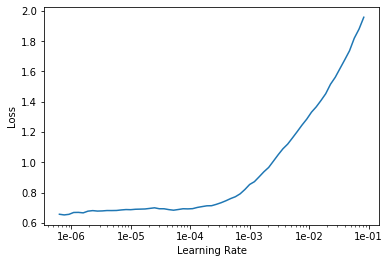

In [19]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(6,1e-4, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

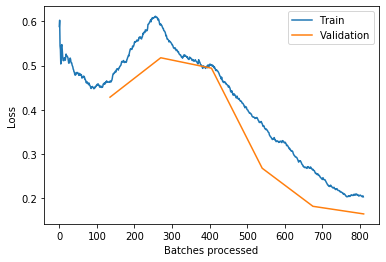

In [22]:
learn.recorder.plot_losses()

In [8]:
data2 = get_data(path_png, tfms=tfms, size=(375,500), bs=32)

In [9]:
img_stats = data2.batch_stats()
data2.normalize(img_stats)

ImageDataBunch;

Train: LabelList (13565 items)
x: ImageList
Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500)
y: CategoryList
casio,casio,nikon,canon,sony
Path: /home/jupyter/images_full/pics;

Valid: LabelList (3391 items)
x: ImageList
Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500)
y: CategoryList
fujifilm,samsung,sony,pentax,samsung
Path: /home/jupyter/images_full/pics;

Test: None

In [13]:
learn = Learner(data2, model, metrics=[accuracy], path='/home/jupyter/')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


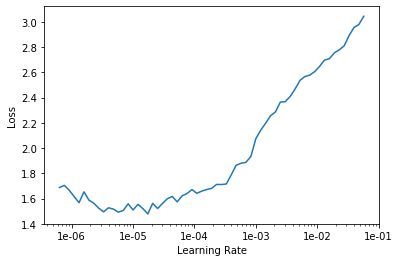

In [39]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.load('bestmodel_5');

In [16]:
learn = learn.batch_loss_filter()

In [48]:
learn.fit_one_cycle(6,7e-5, callbacks=[SaveModelCallback(learn, name='newbest', every='epoch', monitor='accuracy')])

In [18]:
learn.load('newbest_5');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


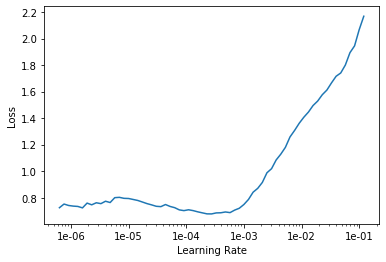

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(6,8e-5, callbacks=[SaveModelCallback(learn, name='newbester', every='epoch', monitor='accuracy')])

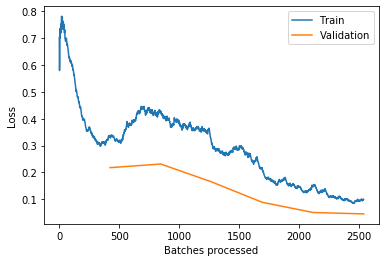

In [21]:
learn.recorder.plot_losses()

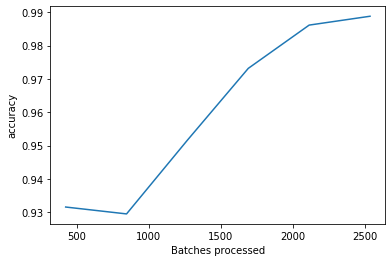

In [22]:
learn.recorder.plot_metrics()

In [ ]:
!git clone https://github.com/sdoria/mish

In [ ]:
%cd mish
from rangerlars import *
from mish import *
from mxresnet import *
from ranger import *
%cd ..

In [ ]:
opt_func = partial(Ranger, betas=(0.9,0.99), eps=1e-6)

In [15]:
import math

class BatchLossFilterCallback(LearnerCallback):
    _order = -20

    def __init__(self, learn:Learner, min_sample_perc:float=0., min_loss_perc:float=0.):
        super().__init__(learn)
        assert min_sample_perc >0. or min_loss_perc > 0., 'min_sample_perc <= 0 and min_loss_perc <= 0'
        self.min_sample_perc, self.min_loss_perc = min_sample_perc, min_loss_perc
        self.learn = learn
        self.model = learn.model
        self.crit = learn.loss_func
        if hasattr(self.crit, 'reduction'):  self.red = self.crit.reduction
        self.sel_losses_sum, self.losses_sum = 0., 0.
        self.sel_samples, self.samples = 0., 0.
        self.recorder.add_metric_names(["loss_perc", "samp_perc"])

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.sel_losses_sum, self.losses_sum = 0., 0.
        self.sel_samples, self.samples = 0., 0.

    def on_batch_begin(self, last_input, last_target, train, epoch, **kwargs):
        if not train or epoch == 0: return
        if hasattr(self.crit, 'reduction'):  setattr(self.crit, 'reduction', 'none')
        with torch.no_grad():  self.losses = np.array(self.crit(self.model(last_input), last_target))
        if hasattr(self.crit, 'reduction'):  setattr(self.crit, 'reduction', self.red)
        self.get_loss_idxs()
        self.sel_losses_sum += self.losses[self.idxs].sum()
        self.losses_sum += self.losses.sum()
        self.sel_samples += len(self.idxs)
        self.samples += len(self.losses)
        return {"last_input": last_input[self.idxs], "last_target": last_target[self.idxs]}

    def on_epoch_end(self, epoch, last_metrics, **kwargs):
        loss_perc = self.sel_losses_sum / self.losses_sum if epoch > 0 else 1.
        sample_perc = self.sel_samples / self.samples if epoch > 0 else 1.
        return add_metrics(last_metrics, [loss_perc, sample_perc])

    def on_train_end(self, **kwargs):
        """At the end of training this calleback will be removed"""
        if hasattr(self.learn.loss_func, 'reduction'):  setattr(self.learn.loss_func, 'reduction', self.red)
        drop_cb_fn(self.learn, 'BatchLossFilterCallback')

    def get_loss_idxs(self):
        idxs = np.argsort(self.losses)[::-1]
        sample_max = math.ceil(len(idxs) * self.min_sample_perc)
        self.losses /= self.losses.sum()
        loss_max = np.argmax(self.losses[idxs].cumsum() >= self.min_loss_perc) + 1
        self.idxs =  list(idxs[:max(sample_max, loss_max)])


def drop_cb_fn(learn, cb_name:str)->None:
    cbs = []
    for cb in learn.callback_fns:
        if isinstance(cb, functools.partial): cbn = cb.func.__name__
        else: cbn = cb.__name__
        if cbn != cb_name: cbs.append(cb)
    learn.callback_fns = cbs


def batch_loss_filter(learn:Learner, min_sample_perc:float=0., min_loss_perc:float=.9)->Learner:
    learn.callback_fns.append(partial(BatchLossFilterCallback, min_sample_perc=min_sample_perc,
                                      min_loss_perc=min_loss_perc))
    return learn

Learner.batch_loss_filter = batch_loss_filter